In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib notebook

In [2]:
class CosmicBody:
    def __init__(self, mas = 1, vec_r = np.array([0, 0]), vec_v = np.array([0, 0])):
        self.mas = mas
        self.vec_r = vec_r
        self.vec_v = vec_v
    def gravity(self, df_t):
        dx = df_t["cor_x"] - self.vec_r[0]
        dy = df_t["cor_y"] - self.vec_r[1]
        dz = df_t["cor_z"] - self.vec_r[2]
        distance = (dx*dx + dy*dy+dz*dz)**(3/2) 
        cor_dvx = ((6.67430*(10**(-11))*df_t["mas"]*df_t["dt"]/distance)*dx).sum()
        cor_dvy = ((6.67430*(10**(-11))*df_t["mas"]*df_t["dt"]/distance)*dy).sum()
        cor_dvz = ((6.67430*(10**(-11))*df_t["mas"]*df_t["dt"]/distance)*dz).sum()
        return np.array([cor_dvx, cor_dvy, cor_dvz])
    def destroy(self, df):
        mask_x = df["cor_x"].apply(lambda x: (round(x,1) <= (self.vec_r[0] + 0.4))&(round(x,1) >= (self.vec_r[0] - 0.4)))
        mask_y = df["cor_y"].apply(lambda y: (round(y,1) <= (self.vec_r[1] + 0.4))&(round(y,1) >= (self.vec_r[1] - 0.4)))
        mask_z = df["cor_z"].apply(lambda z: (round(z,1) <= (self.vec_r[2] + 0.4))&(round(z,1) >= (self.vec_r[2] - 0.4)))
        if df[(mask_x)&(mask_y)&(mask_z)]["cor_x"].count() > 1:
            df.drop(df[(mask_x)&(mask_y)&(mask_z)].index, axis = 0, inplace = True)
    

In [3]:
class System:
    def __init__(self, dt, t, df):
        self.dt = dt
        self.t = t
        self.df = df
    def step(self):
        self.t += self.dt
        df_t = self.df[self.df["time"].apply(lambda x: x <= self.t)]
        body = CosmicBody()
        for i in df_t.index:
            body.vec_r = np.array([df_t["cor_x"][i], df_t["cor_y"][i], df_t["cor_z"][i]])
            body.vec_v = np.array([df_t["cor_vx"][i], df_t["cor_vy"][i], df_t["cor_vz"][i]])
            body.mas = df_t["mas"][i]
            vec_dv = body.gravity(df_t[df_t.index != i])
            body.vec_r = body.vec_r + body.vec_v*self.dt + vec_dv*self.dt/2 
            self.df.loc[i, "cor_x"] = body.vec_r[0] 
            self.df.loc[i, "cor_y"] = body.vec_r[1]
            self.df.loc[i, "cor_z"] = body.vec_r[2]
            self.df.loc[i, "cor_vx"] = body.vec_v[0] + vec_dv[0]
            self.df.loc[i, "cor_vy"] = body.vec_v[1] + vec_dv[1]
            self.df.loc[i, "cor_vz"] = body.vec_v[2] + vec_dv[2]
            body.destroy(self.df)
    def show(self):
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        p = 4
        for t in tqdm(np.arange(0., 4, self.dt)):
            p += 0.02
            angle = 60 + 60 * p / 10
            ax.clear()
            ax.axes.set_xlabel("X")
            ax.axes.set_ylabel("Y")
            ax.axes.set_zlabel("Z") 
            ax.axes.set_xlim3d(-30, 30)
            ax.axes.set_ylim3d(-30, 30)
            ax.axes.set_zlim3d(-30, 30)
            df_t0 = self.df[self.df["time"].apply(lambda x: x <= self.t)]
            ax.scatter(df_t0["cor_x"], df_t0["cor_y"], df_t0["cor_z"], c = df_t0["color"], s = df_t0["size"])
            ax.view_init(30 - angle * 0.2, angle)
            fig.canvas.draw()
            self.step()

In [5]:
df = pd.read_csv("Planets.csv")
df.head()

,mas,cor_x,cor_y,cor_z,cor_vx,cor_vy,cor_vz,time,dt,color,size
0,1.000000e+15,0.0,0.0,0.0,0.00,0.0,0.0,0,0.01,y,120
1,1.000000e-03,0.0,5.0,0.0,0.00,0.0,115.5,0,0.01,b,30
2,2.000000e+00,0.0,10.0,0.0,81.67,0.0,0.0,0,0.01,c,40
3,1.000000e-02,-2.0,10.0,0.0,0.00,82.0,0.0,0,0.01,g,30
4,1.000000e-01,-100.0,-100.0,0.0,69.00,69.0,0.0,0,0.01,k,70


<IPython.core.display.Javascript object>


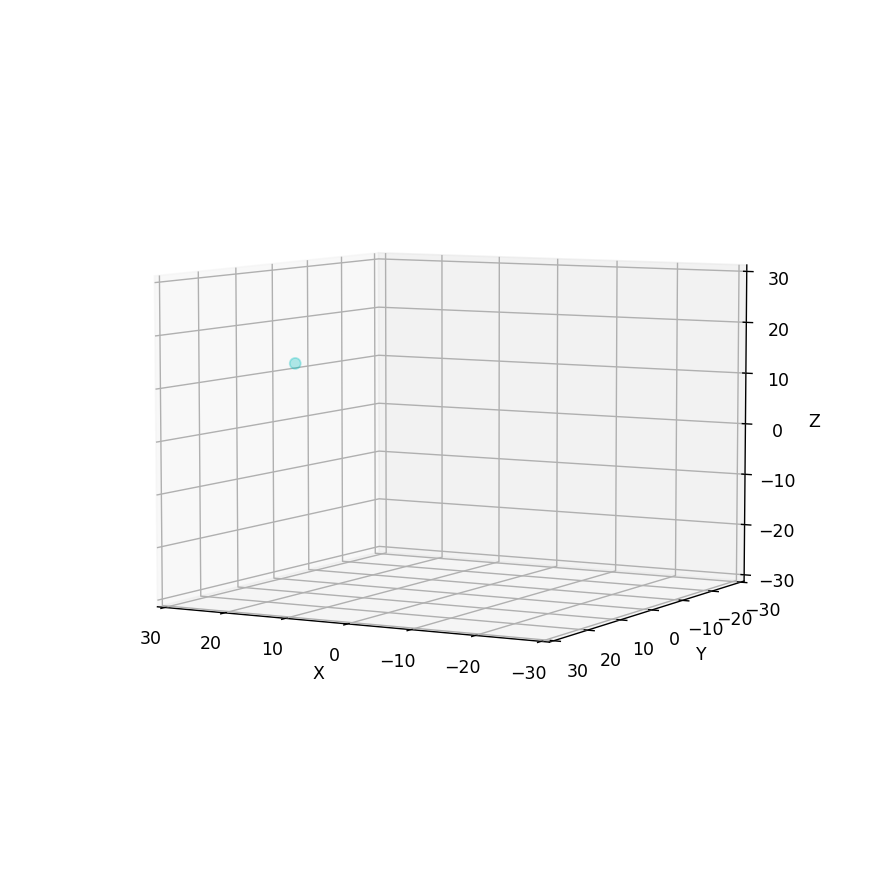

 72%|██████████████████████████████████████████████████████████                      | 290/400 [00:30<00:11,  9.60it/s]


KeyboardInterrupt: 

In [6]:
Bodies_System = System(df["dt"][0], 0, df)
Bodies_System.show()